In [2]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd

## Function definition

In [3]:
from scipy import stats
def plot_psd_with_ci(epochs, channel, fmin, fmax, err_method, 
                     grouper, notch_me=True, save_fig=False, 
                     fig_title=f'Average (PSD)', method='multitaper', **kwargs):
    # Extract metadata
    metadata = epochs.metadata
    groups = metadata[grouper].unique()
    colors = sns.color_palette('tab10', 12)
    freq_bands = {
        r'$\delta$': (1, 4),  # Delta
        r'$\theta$': (4, 8),  # Theta
        r'$\alpha$': (8, 13),  # Alpha
        r'$\beta$': (13, 30),  # Beta
        r'$\gamma$': (30, 100)  # Gamma
    }
    epochs_ = epochs.copy()
    if notch_me:
        for i in range(len(epochs_)):
            epochs_._data[i] = mne.filter.notch_filter(epochs_._data[i], epochs.info['sfreq'], [50], 
                            notch_widths=1, method='spectrum_fit', verbose=False)


    # Initialize plot
    fig, ax = plt.subplots(figsize=(16, 12))

    for i, group in enumerate(groups):
        # Select epochs for the current group
        group_epochs = epochs_[metadata[grouper] == group]
        
        if method == 'multitaper':
            psds, freqs = mne.time_frequency.psd_array_multitaper(group_epochs.get_data(picks=channel), fmin=fmin, fmax=fmax, sfreq=epochs.info['sfreq'], **kwargs)
        elif method == 'welch':             # TODO welch?????????????? shook
            psds, freqs = group_epochs.compute_psd(method='welch', picks=channel, fmin=fmin, fmax=fmax, **kwargs).get_data(picks=channel)
        else:
            raise NotImplementedError('Please chose either "welch", or "multitaper" for method')
        
        mean_psd = np.mean(psds[:, 0, :], axis=0)
        if err_method == 'ci':
            err = 1.96 * np.std(psds[:, 0, :], axis=0) / np.sqrt(psds.shape[0])  # 95% confidence interval
        elif err_method == 'sd':
            err = np.std(psds[:, 0, :], axis=0)
        
    # Plot
        ax.plot(freqs, 10 * np.log10(mean_psd), label=group, color=colors[i])
        ax.fill_between(freqs, 10 * np.log10(mean_psd - err), 10 * np.log10(mean_psd + err), alpha=0.2, color=colors[i])

    
     # Add vertical lines and labels for frequency bands
    for band, (start, end) in freq_bands.items():
        ax.axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        ax.axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        ax.text((start + end) / 2, ax.get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power/Frequency (dB/Hz)')
    ax.set_title( f'{fig_title} - {channel}')
    plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
    
    factor = 1.5  # Scale factor
    for text_obj in plt.findobj(match=plt.Text):
        text_obj.set_fontsize(text_obj.get_fontsize() * factor)

    if save_fig:
        plt.savefig(f'plots/PSD_{fig_title}_{channel}.pdf')
    else:
        plt.show()

In [4]:
# Epochs paths
all_sniff_path = "epochs\concatenated\concat_social_sniff-epo.fif"
all_approaches_path = "epochs\concatenated\concat_social_approach-epo.fif"

# Load data
ep_sniff = mne.read_epochs(all_sniff_path)
ep_approach = mne.read_epochs(all_approaches_path)

Reading c:\Users\lisan\OneDrive\Bureaublad\RP\EEG_acute_colonies\epochs\concatenated\concat_social_sniff-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...     498.75 ms
        0 CTF compensation matrices available
Adding metadata with 19 columns
1043 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\lisan\OneDrive\Bureaublad\RP\EEG_acute_colonies\epochs\concatenated\concat_social_approach-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...     998.42 ms
        0 CTF compensation matrices available
Adding metadata with 19 columns
947 matching events found
No baseline correction applied
0 projection items activated


### Applying notch filtering

In [5]:
def notch_epochs(epochs, notch_freqs = [50], **kwargs):
    epochs_ = epochs.copy()
    for i in range(len(epochs_)):
        epochs_._data[i] = mne.filter.notch_filter(epochs_._data[i], epochs.info['sfreq'],notch_freqs, **kwargs)
    return epochs_

In [6]:
notched_ep_sniff = notch_epochs(ep_sniff, notch_widths=1, method='spectrum_fit', verbose=False)

In [7]:
notched_ep_approach = notch_epochs(ep_approach, notch_widths=1, method='spectrum_fit', verbose=False)

Check difference of the raw between notched and not notched epochs

Text(0.5, 1.0, 'After Notch Social_Sniff')

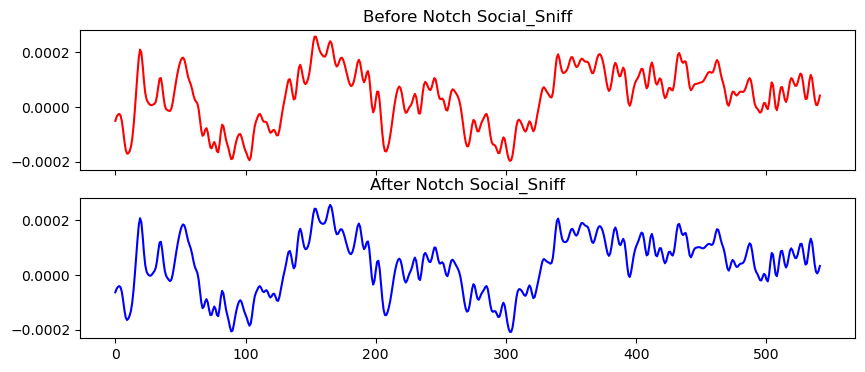

In [10]:
# Select behavior type, load either SNIFF or APPROACH
epochs = ep_sniff
notched_eps = notched_ep_sniff
# epochs = ep_approach
# notched_eps = notched_ep_approach

if epochs is ep_sniff:
    behavior_name = "Social_Sniff"
else:
    behavior_name = "Social_Approach"

# select no of events
epoch_idx = len(epochs.events)-1

fig, ax = plt.subplots(nrows=2, figsize=(10, 4), sharex=True, sharey=True)

ax[0].plot(epochs.get_data(picks=['OFC_left'])[epoch_idx][0], color='r')
ax[1].plot(notched_eps.get_data(picks=['OFC_left'])[epoch_idx][0], color='b')
ax[0].set_title(f'Before Notch {behavior_name}')
ax[1].set_title(f'After Notch {behavior_name}')

Check the difference in PSD

    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows


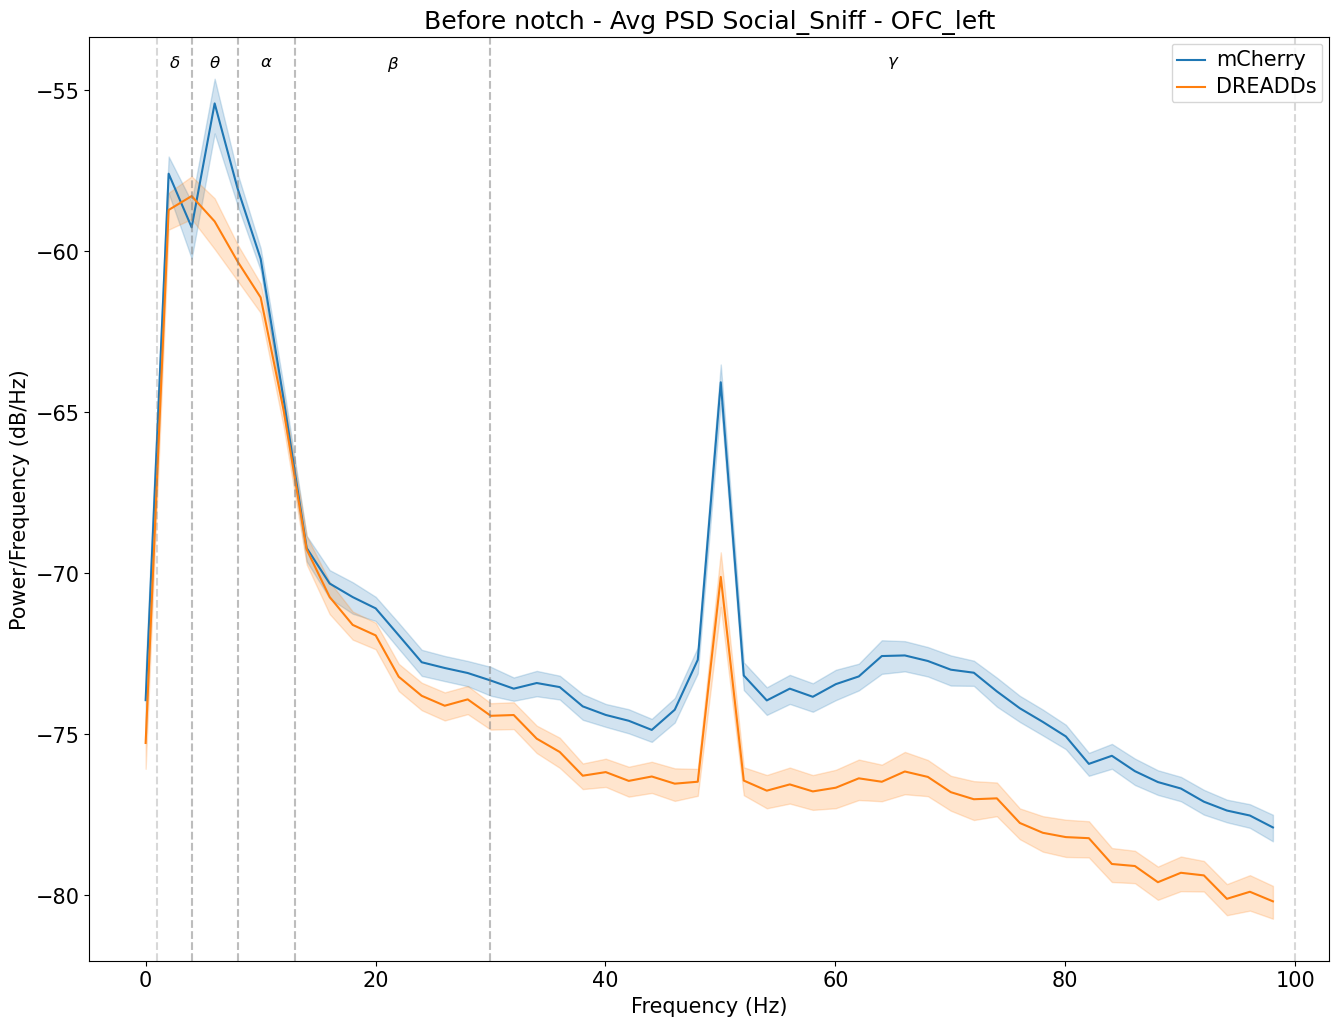

In [55]:
plot_psd_with_ci(epochs, 'OFC_left', 0, 100, "ci", 'surgery', 
                 notch_me=False, save_fig=False, 
                 fig_title= f'Before notch - Avg PSD {behavior_name}', method='multitaper', bandwidth=3)

    Using multitaper spectrum estimation with 2 DPSS windows
    Using multitaper spectrum estimation with 2 DPSS windows


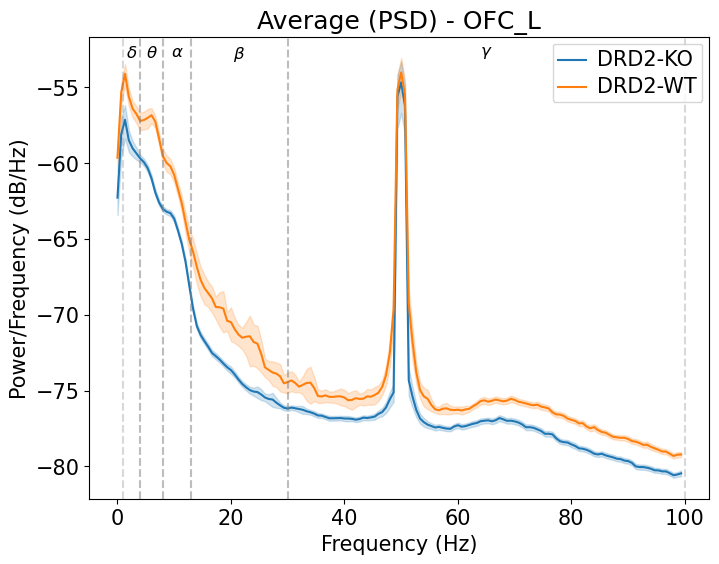

In [23]:
# VAS code
plot_psd_with_ci(ep1, 'OFC_L', 0, 100, "ci", 'genotype', notch_me=False, save_fig=False, fig_title='Before notch', method='multitaper', bandwidth=2)

After notch

    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows


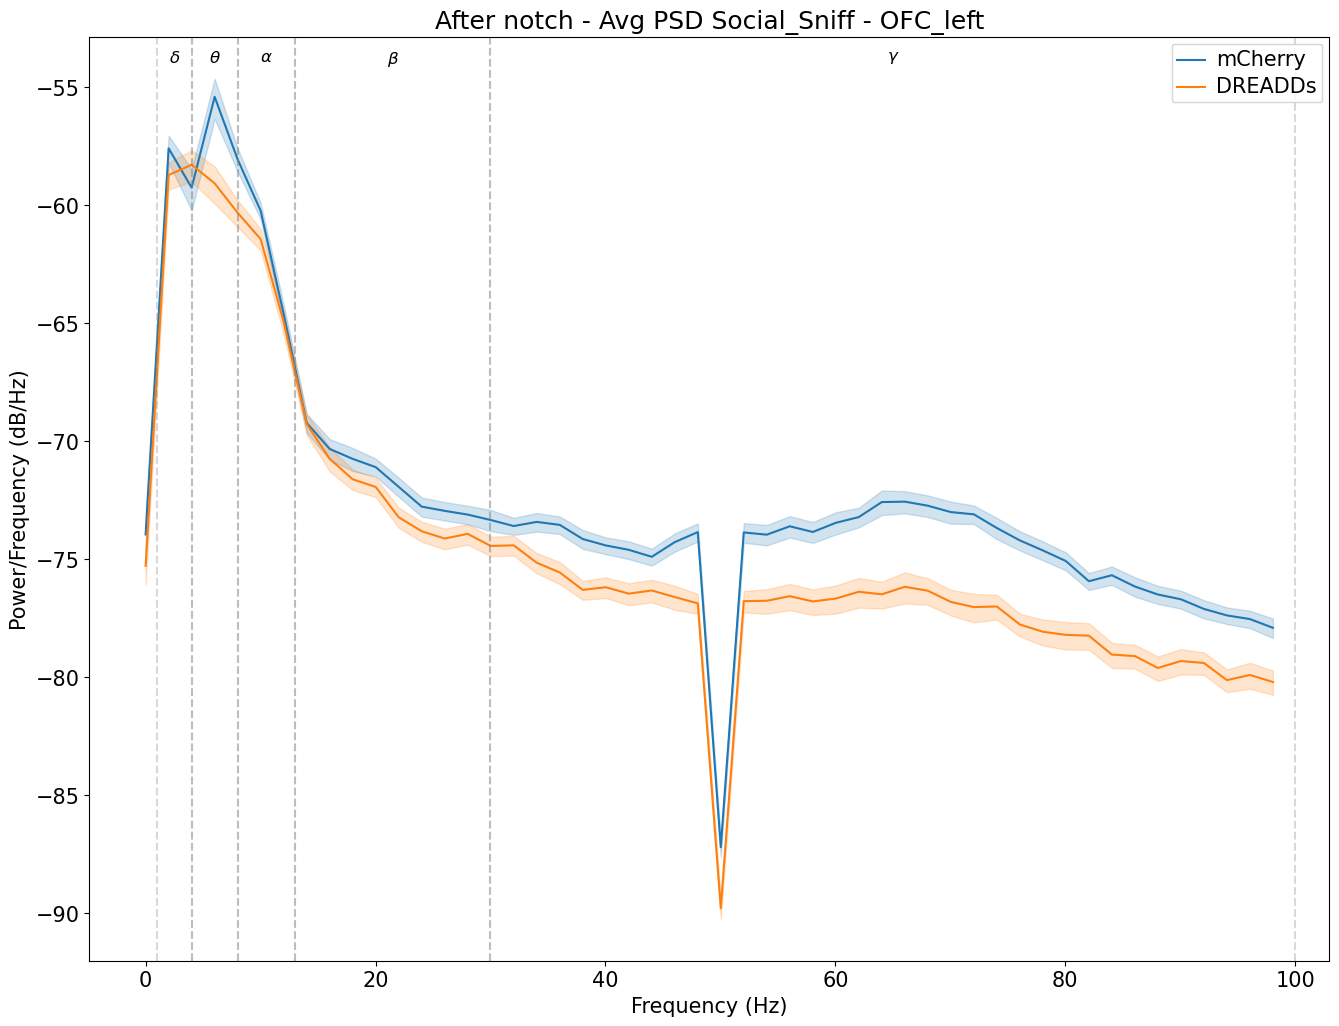

In [57]:
plot_psd_with_ci(notched_eps, 'OFC_left', 0, 100, "ci", 'unique_g', 
                 notch_me=False, save_fig=False, 
                 fig_title=f'After notch - Avg PSD {behavior_name}', method='multitaper', bandwidth=3)

## Save notched epochs

In [24]:
notched_ep_sniff.save('epochs\p8-b2_all-sniffs_notch-epo.fif')

In [25]:
notched_ep_approach.save('epochs\p8_b2_all-approaches_notch-epo.fif')

# Examine DBSCAN epochs

In [60]:
# Load clustering results
clusters_approach = pd.read_excel(r"feature_dfs\features_Social_Approach_clusters.xlsx")
clusters_sniff = pd.read_excel(r"feature_dfs\features_Social_Sniff_clusters.xlsx")

In [68]:
# Extract epochs from clustering results
epochs_sub_sniff = epochs_sniff[clusters_sniff['clusters_label']==0]
epochs_sub_approach = epochs_approach[clusters_approach['clusters_label']==0]

# Add column to the metadata for plotting
epochs_sub_approach.metadata['animal_injection'] = epochs_sub_approach.metadata['animal_id'] + '-' + epochs_sub_approach.metadata['injection']
epochs_sub_sniff.metadata['animal_injection'] = epochs_sub_sniff.metadata['animal_id'] + '-' + epochs_sub_sniff.metadata['injection']

# Examine dataset sizes

In [64]:
def annot(bar_plot):
    for p in bar_plot.patches:
        bar_plot.annotate(format(p.get_height(), '.1f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', va = 'center', 
                      xytext = (0, 9), 
                      textcoords = 'offset points', fontsize=8)

In [65]:
# mt2 = pd.read_excel("D:\RA\DRD2 project\DRD2_EEG_all_animal_info.xlsx", dtype={'mouseId':int})
# batch = mt2[['mouseId', 'batch']].drop_duplicates()
# batch = batch.rename(columns={'mouseId':'animal_id'})

# batch

,animal_id,batch
0,78211,1
1,78212,1
2,78213,1
3,78210,1
4,78233,1
...,...,...
91,39498,6
92,39508,6
93,39499,6
94,39507,6


In [84]:
mt = epochs_sub_approach.metadata.copy()
mt.animal_id = mt.animal_id.astype(str)
# mt = pd.merge(mt, batch, on='animal_id')
print('Sample Size:')
print( mt[['animal_id', 'injection']].drop_duplicates()['injection'].value_counts()) # 7 because one day is missing

print('Per unique group')
print( mt['unique_groups'].value_counts()) 

print('Epochs per surgery type:')
print(mt['surgery'].value_counts())

print('Epochs per compound injection type:')
print(mt['injection'].value_counts())

print('Epochs per day:')
# print(mt[['day', 'surgery']].value_counts())
print(mt['day'].value_counts())

Sample Size:
injection
B    7
A    7
Name: count, dtype: int64
Per unique group
unique_groups
mCherry-B    306
DREADDs-A    245
DREADDs-B    211
mCherry-A    172
Name: count, dtype: int64
Epochs per surgery type:
surgery
mCherry    478
DREADDs    456
Name: count, dtype: int64
Epochs per compound injection type:
injection
B    517
A    417
Name: count, dtype: int64
Epochs per day:
day
1    197
4    149
3    138
7    128
8    125
2    120
6     77
Name: count, dtype: int64


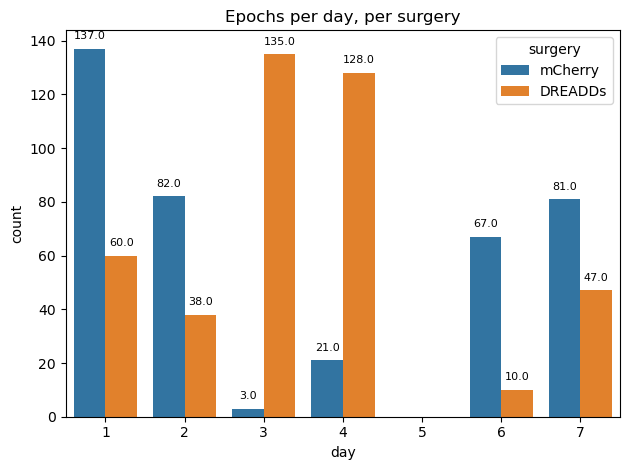

In [88]:
# Calculate the value counts and convert to DataFrame
count_data = mt[['day', 'unique_groups']].value_counts().reset_index(name='count')
count_data['day'] = count_data['day'].astype(int)

# Create the bar plot
# sns.set(style="whitegrid")
bar_plot = sns.barplot(data=count_data, y='count', x='day', hue='unique_groups', order=np.arange(1, 8))
annot(bar_plot)
plt.title('Epochs per day, per surgery/injection combination')
plt.tight_layout()

In [102]:
# Calculate the number of epochs for each animal
epoch_counts = mt['animal_id'].value_counts()
epoch_counts = mt[[ 'surgery', 'animal_id', 'injection', 'arena']].value_counts().reset_index(name='count')

epoch_counts['percentage'] = epoch_counts['count'] / epoch_counts['count'].sum() * 100

epoch_counts

,surgery,animal_id,injection,arena,count,percentage
0,mCherry,8.9,B,1,137,14.668094
1,DREADDs,8.11,B,1,135,14.453961
2,DREADDs,8.11,A,1,128,13.704497
3,mCherry,8.14,A,3,87,9.314775
4,mCherry,8.9,A,1,82,8.779443
5,mCherry,8.14,B,3,81,8.672377
6,mCherry,8.10,B,1,67,7.173448
7,DREADDs,8.15,A,3,60,6.423983
8,DREADDs,8.12,A,1,47,5.032120
9,DREADDs,8.12,B,1,38,4.068522


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, '8.9'),
  Text(1, 0, '8.11'),
  Text(2, 0, '8.14'),
  Text(3, 0, '8.10'),
  Text(4, 0, '8.15'),
  Text(5, 0, '8.12'),
  Text(6, 0, '8.13'),
  Text(7, 0, '8.16')])

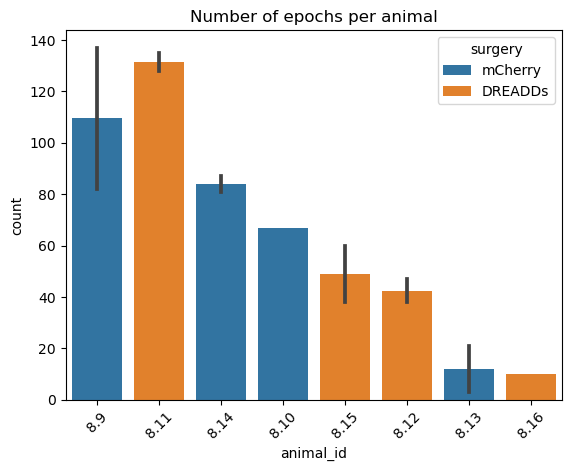

In [105]:
sns.barplot(data=epoch_counts, x='animal_id', y='count', hue='surgery', dodge=False)
plt.title('Number of epochs per animal')
plt.xticks(rotation=45)

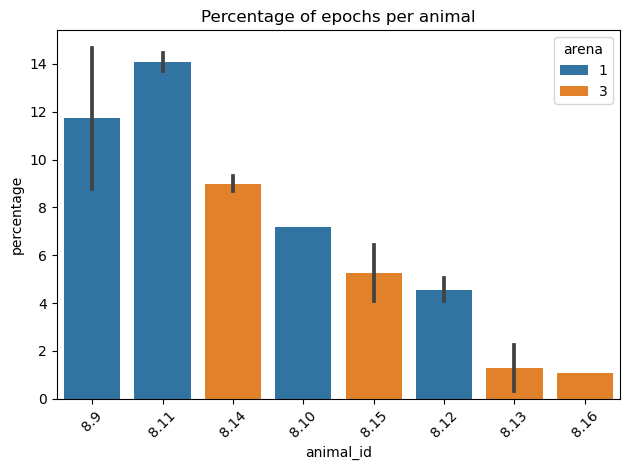

In [104]:
sns.barplot(data=epoch_counts, x='animal_id', y='percentage', hue='arena', dodge=False)
#rotate x axis
plt.xticks(rotation=45)
plt.title('Percentage of epochs per animal')
plt.tight_layout()